<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Projects/blob/master/EndWaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Your challenge is to write a function, find_stopped_images, that takes in an image and returns an array of image paths in that directory that are of stopped belts.


For instance, if image_dir contains the images 1.jpg, 2.jpg, … 100.jpg and images 75 - 90 are stopped, you should return the array [image_dir/75.jpg,image_dir/76.jpg, … image_dir/90.jpg].

As part of exploring methods to detect identical or nearly identical images, I researched common approaches and identified two widely used techniques: perceptual hashing and the Structural Similarity Index Measure (SSIM). I implemented both and began evaluating their performance on our dataset.

In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
import os
from PIL import Image
import imagehash
import cv2
import matplotlib.pyplot as plt

def find_stopped_images_phash(image_dir, hash_threshold=6):
    """
    Detect stopped frames using perceptual hashing (pHash), experimented with different hash_threshold from 4-6.
    Returns a list of image paths considered as stopped frames.

    A frame is "stopped" if it's visually identical (or nearly so) to the previous one.
    The first stopped frame in a still period is ignored.
    """
    # Sort images by timestamp (filename)
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))],
        key=lambda x: float(os.path.splitext(x)[0])
    )

    stopped_images = []
    prev_hash = None
    first_same = True  # To skip the first still frame in a stopped sequence

    for filename in image_files:
        path = os.path.join(image_dir, filename)

        try:
            img = Image.open(path).convert('L')  # Grayscale
        except:
            continue

        curr_hash = imagehash.phash(img)

        if prev_hash is not None:
            hamming_distance = prev_hash - curr_hash

            if hamming_distance <= hash_threshold:
                if first_same:
                    # Skip the first frame in a "stopped" sequence
                    first_same = False
                else:
                    stopped_images.append(path)
            else:
                first_same = True  # Reset on motion detected

        prev_hash = curr_hash

    return stopped_images

def show_stopped_images(image_paths, max_images=20):
    """
    Visualize up to `max_images` stopped belt frames.
    """
    n = min(len(image_paths), max_images)
    if n == 0:
        print("No stopped frames detected.")
        return

    plt.figure(figsize=(15, 3 * ((n + 4) // 5)))

    for i in range(n):
        img = cv2.imread(image_paths[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot((n + 4) // 5, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(os.path.basename(image_paths[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Found 11 stopped images.


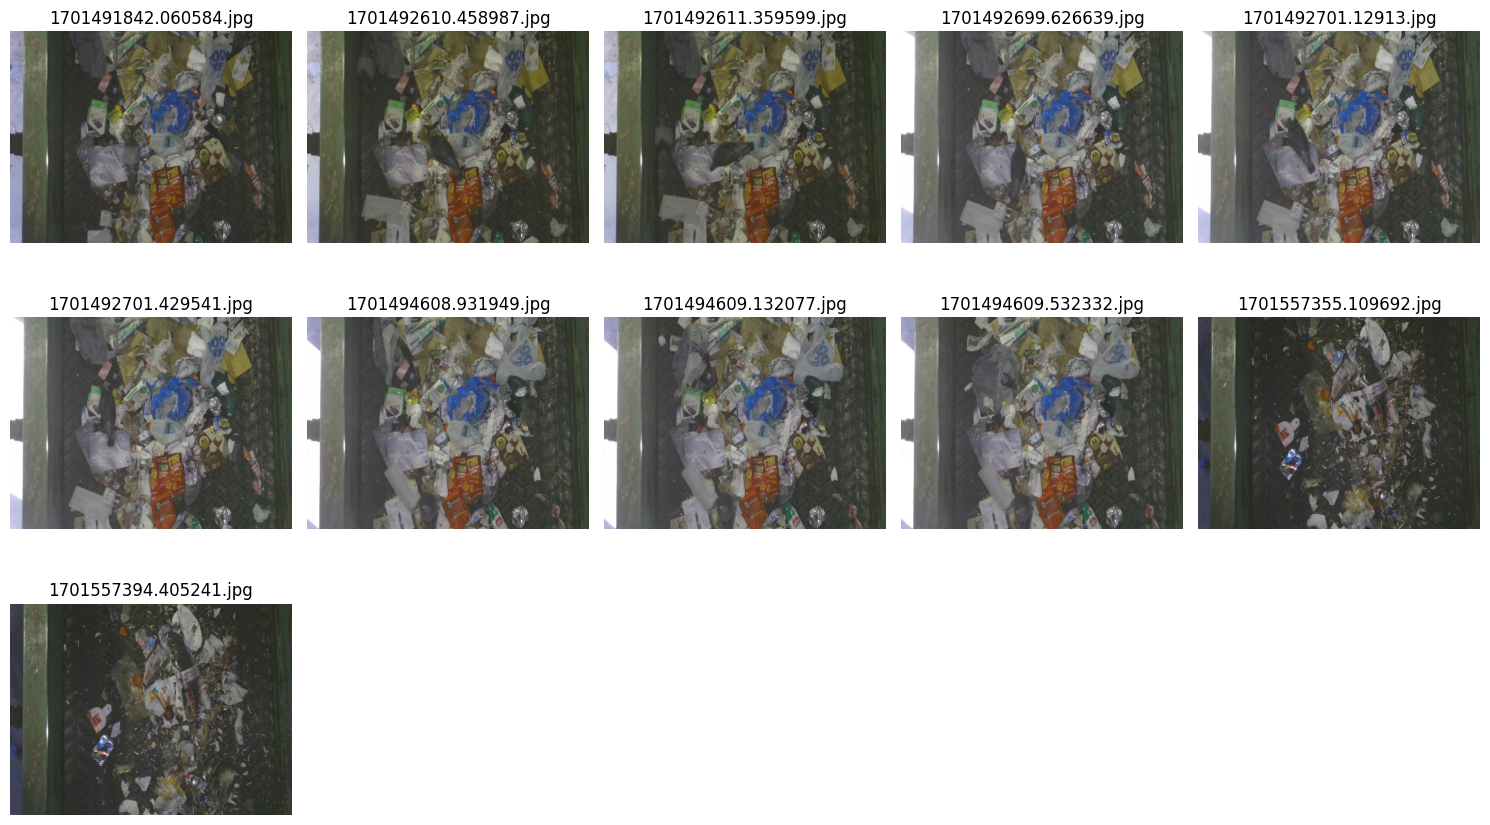

In [ ]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/belt_images"
stopped_images = find_stopped_images_phash(image_dir)
print(f"Found {len(stopped_images)} stopped images.")
# Call the visualization
show_stopped_images(stopped_images, max_images=15)

While experimenting with SSIM, I initially used the commonly recommended threshold of 0.95. However, I noticed that even when the conveyor belt was static, the presence of moving elements like pigeons caused the SSIM score to fluctuate unexpectedly. To address this, I lowered the threshold to 0.9, which provided better tolerance for such background activity.

Since the primary goal was to detect belt motion specifically, I also leveraged optical flow — a technique I’ve previously found effective for motion detection tasks. I combined the SSIM and optical flow metrics to create a more robust solution. After analyzing the results across image pairs, I observed that a combination of SSIM > 0.9 and optical flow magnitude < 1.0 successfully identified the majority of relevant cases in the dataset.

Some limitations of this approach include:

1. Camera vibrations or shake, which can falsely impact both SSIM and flow values.

2. Lighting flicker or sudden illumination changes, which affect SSIM sensitivity.

3. Unexpected objects (e.g., pigeons landing on the belt), which introduce local motion and reduce the reliability of motion-based metrics.

This process of experimentation, parameter tuning, and metric fusion helped me design a reliable approach tailored to the specific characteristics of our visual data.

In [ ]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

def show_stopped_images(image_paths, max_images=20):
    """
    Visualize up to `max_images` stopped belt frames.
    """
    n = min(len(image_paths), max_images)
    if n == 0:
        print("No stopped frames detected.")
        return

    plt.figure(figsize=(15, 3 * ((n + 4) // 5)))

    for i in range(n):
        img = cv2.imread(image_paths[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot((n + 4) // 5, 5, i + 1)
        plt.imshow(img_rgb)
        plt.title(os.path.basename(image_paths[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def compute_optical_flow(prev_img, next_img):
    """Compute average optical flow magnitude between two grayscale images."""
    flow = cv2.calcOpticalFlowFarneback(prev_img, next_img,
                                        None, 0.5, 3, 15, 3, 5, 1.2, 0)
    magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    avg_magnitude = np.mean(magnitude)
    return avg_magnitude

def find_stopped_images(image_dir, ssim_threshold=0.95, flow_threshold=0.5):
    """
    Detect stopped belt images based on SSIM and Optical Flow,
    experimented
    """
    image_files = sorted(
        [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))],
        key=lambda x: float(os.path.splitext(x)[0])
    )

    stopped_images = []

    prev_img = None

    for i, filename in enumerate(image_files):
        path = os.path.join(image_dir, filename)
        prev_path = os.path.join(image_dir, image_files[i - 1]) if i > 0 else None
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue

        img = cv2.GaussianBlur(img, (5, 5), 0)

        if prev_img is not None:
            # Resize current image to match previous image if needed
            if img.shape != prev_img.shape:
                img = cv2.resize(img, (prev_img.shape[1], prev_img.shape[0]))

            # SSIM
            ssim_score, _ = ssim(prev_img, img, full=True)

            # Optical Flow
            flow_mag = compute_optical_flow(prev_img, img)

            print(f"{filename}: SSIM={ssim_score:.3f}, Flow={flow_mag:.3f}")

            # If both conditions are met: consider image "stopped"
            if ssim_score > ssim_threshold and flow_mag < flow_threshold:
                stopped_images.append(path)
                show_stopped_images([prev_path, path], max_images=2)

        prev_img = img

    return stopped_images


1701418626.807322.jpg: SSIM=0.577, Flow=6.773
1701418627.140839.jpg: SSIM=0.580, Flow=6.441
1701418895.997868.jpg: SSIM=0.615, Flow=8.105
1701418896.264746.jpg: SSIM=0.672, Flow=6.981
1701419179.467135.jpg: SSIM=0.604, Flow=7.734
1701419468.806347.jpg: SSIM=0.656, Flow=2.965
1701419469.073207.jpg: SSIM=0.922, Flow=0.617


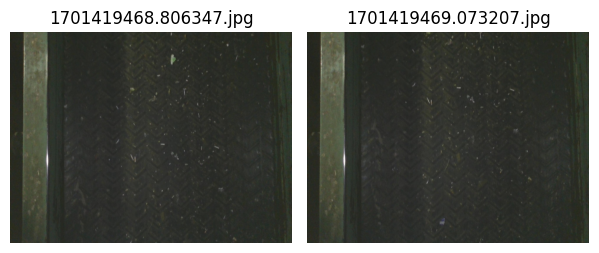

1701419469.373431.jpg: SSIM=0.906, Flow=0.820


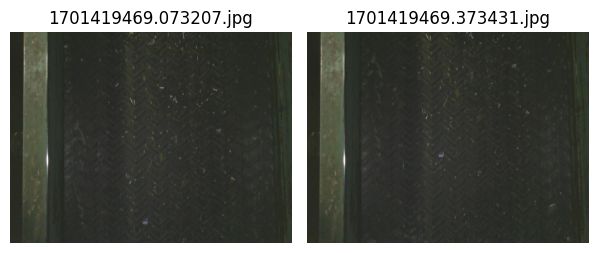

1701420761.574738.jpg: SSIM=0.712, Flow=3.454
1701420761.874881.jpg: SSIM=0.646, Flow=5.686
1701420762.141671.jpg: SSIM=0.681, Flow=5.359
1701426257.00161.jpg: SSIM=0.638, Flow=6.307
1701426257.368858.jpg: SSIM=0.629, Flow=5.432
1701427742.440738.jpg: SSIM=0.616, Flow=5.857
1701427742.740628.jpg: SSIM=0.585, Flow=7.030
1701427743.040494.jpg: SSIM=0.584, Flow=7.183
1701427743.340573.jpg: SSIM=0.595, Flow=7.367
1701428148.506671.jpg: SSIM=0.567, Flow=8.519
1701428148.80674.jpg: SSIM=0.547, Flow=7.663
1701428149.173503.jpg: SSIM=0.568, Flow=8.627
1701430181.971905.jpg: SSIM=0.588, Flow=6.548
1701430182.272135.jpg: SSIM=0.611, Flow=6.594
1701430374.709446.jpg: SSIM=0.643, Flow=7.516
1701430375.009655.jpg: SSIM=0.675, Flow=6.114
1701430772.695067.jpg: SSIM=0.683, Flow=5.492
1701430772.995445.jpg: SSIM=0.773, Flow=5.618
1701431665.372463.jpg: SSIM=0.655, Flow=5.020
1701431665.706614.jpg: SSIM=0.601, Flow=7.153
1701431851.573574.jpg: SSIM=0.544, Flow=7.647
1701432104.822353.jpg: SSIM=0.543, F

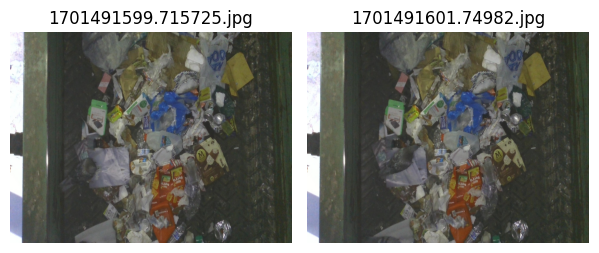

1701491614.260685.jpg: SSIM=0.948, Flow=0.744


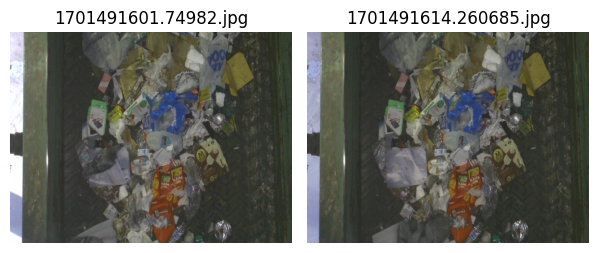

1701491841.460266.jpg: SSIM=0.792, Flow=1.907
1701491841.760413.jpg: SSIM=0.968, Flow=0.335


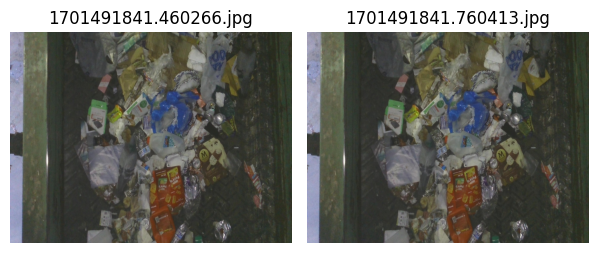

1701491842.060584.jpg: SSIM=0.970, Flow=0.316


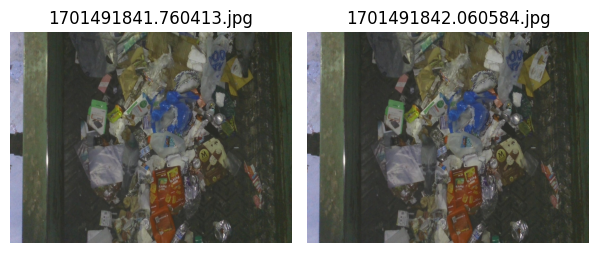

1701492226.544149.jpg: SSIM=0.849, Flow=1.819
1701492609.791926.jpg: SSIM=0.838, Flow=1.209
1701492610.125477.jpg: SSIM=0.966, Flow=0.304


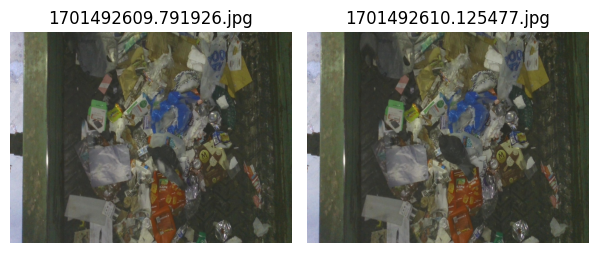

1701492610.458987.jpg: SSIM=0.968, Flow=0.265


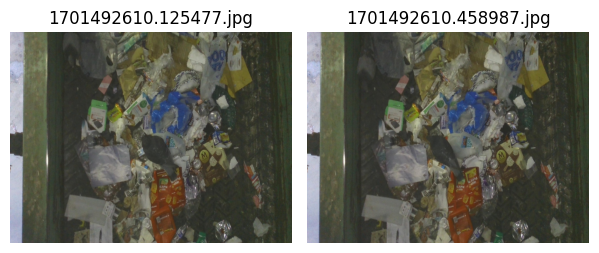

1701492611.359599.jpg: SSIM=0.964, Flow=0.267


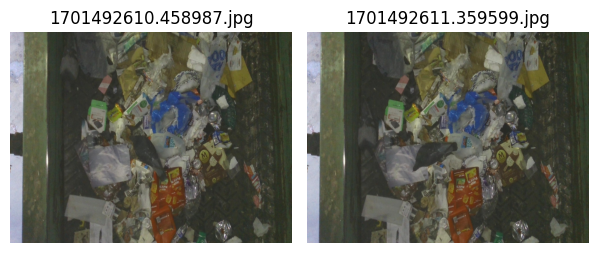

1701492699.626639.jpg: SSIM=0.885, Flow=1.017
1701492701.12913.jpg: SSIM=0.966, Flow=0.267


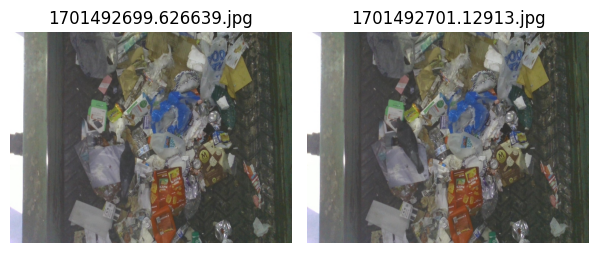

1701492701.429541.jpg: SSIM=0.970, Flow=0.254


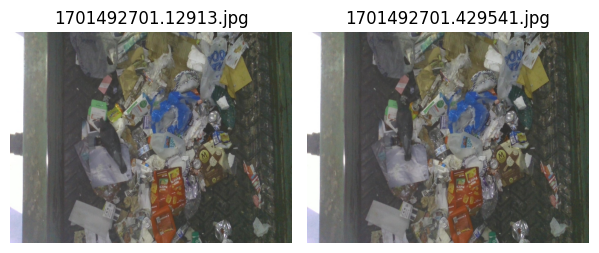

1701494453.654154.jpg: SSIM=0.740, Flow=2.993
1701494608.565044.jpg: SSIM=0.901, Flow=1.075
1701494608.931949.jpg: SSIM=0.960, Flow=0.377


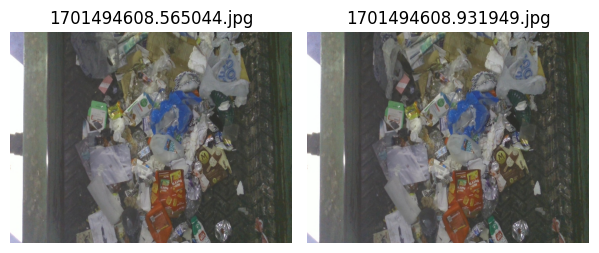

1701494609.132077.jpg: SSIM=0.959, Flow=0.500


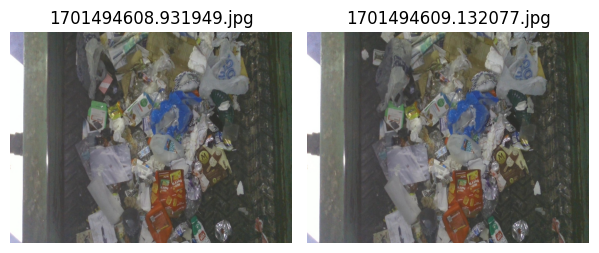

1701494609.532332.jpg: SSIM=0.945, Flow=0.577


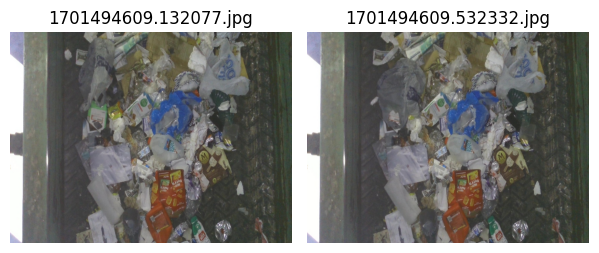

1701496236.450873.jpg: SSIM=0.773, Flow=2.853
1701497728.258401.jpg: SSIM=0.565, Flow=7.769
1701497728.625062.jpg: SSIM=0.592, Flow=6.509
1701497728.925068.jpg: SSIM=0.588, Flow=6.691
1701497729.325055.jpg: SSIM=0.565, Flow=8.192
1701498939.925589.jpg: SSIM=0.590, Flow=6.273
1701498940.225732.jpg: SSIM=0.656, Flow=7.445
1701500106.94514.jpg: SSIM=0.623, Flow=7.945
1701500107.31239.jpg: SSIM=0.629, Flow=7.080
1701505360.566326.jpg: SSIM=0.580, Flow=7.714
1701505733.368778.jpg: SSIM=0.594, Flow=6.002
1701505815.392765.jpg: SSIM=0.618, Flow=6.467
1701505815.693074.jpg: SSIM=0.642, Flow=6.332
1701505815.99324.jpg: SSIM=0.649, Flow=6.371
1701506697.160663.jpg: SSIM=0.601, Flow=8.137
1701506697.49423.jpg: SSIM=0.577, Flow=8.154
1701506697.828149.jpg: SSIM=0.574, Flow=9.395
1701510396.040495.jpg: SSIM=0.608, Flow=6.037
1701513889.846522.jpg: SSIM=0.610, Flow=8.033
1701514408.354049.jpg: SSIM=0.592, Flow=7.851
1701514408.654209.jpg: SSIM=0.614, Flow=8.615
1701514825.888606.jpg: SSIM=0.624, Flo

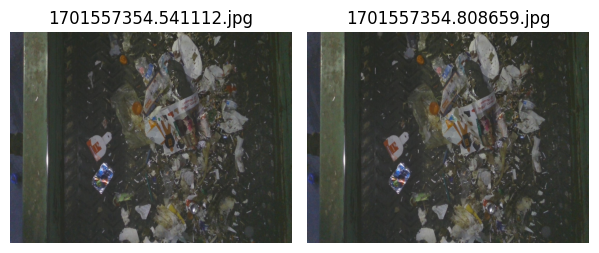

1701557355.109692.jpg: SSIM=0.962, Flow=0.287


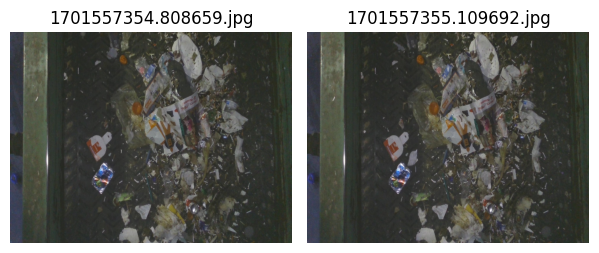

1701557394.405241.jpg: SSIM=0.966, Flow=0.259


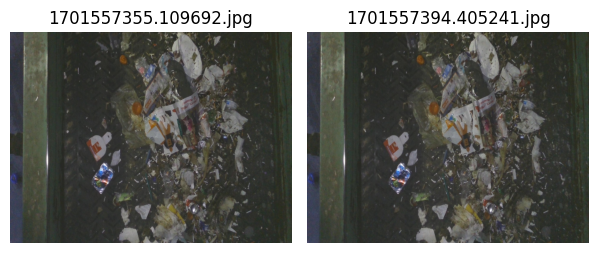

Found 17 stopped images.


In [ ]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/belt_images"
stopped_images = find_stopped_images(image_dir, ssim_threshold=0.90, flow_threshold=1.0)
print(f"Found {len(stopped_images)} stopped images.")
# Call the visualization
# show_stopped_images(stopped_images, max_images=15)